## Setup

In [1]:
import torch
import os
import numpy as np
import pandas as pd
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import dill
import pickle
import re
import json
import lightning.pytorch as pl
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet

# For plotting
from sklearn.neighbors import KernelDensity
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
# from matplotlib import colormaps
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"

# Paths, lags and lead, time index (weekly resolution)
BASE_PATH = 'D:/KIMoDIs/global-groundwater-models-main'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
RESULT_PATH = os.path.join(BASE_PATH, 'results')
FIGURES_PATH = os.path.join(BASE_PATH, 'figures')
SHARE_PATH = 'J:/Berlin/B22-FISHy/NUTZER/Kunz.S'
CACHE_PATH = os.path.join(BASE_PATH, 'cache')

LAG = 52  # weeks
LEAD = 12  # weeks

# Roughly 80/10/10
TRAIN_PERIOD = (pd.Timestamp(1990, 1, 1), pd.Timestamp(2010, 1, 1))
VAL_PERIOD = (pd.Timestamp(2010, 1, 1), pd.Timestamp(2013, 1, 1))
TEST_PERIOD = (pd.Timestamp(2013, 1, 1), pd.Timestamp(2016, 1, 1))

TIME_IDX = pd.date_range(TRAIN_PERIOD[0], TEST_PERIOD[1], freq='W-SUN', inclusive='neither', name='time').to_frame().reset_index(drop=True)
TIME_IDX.index.name = 'time_idx'
TIME_IDX = TIME_IDX.reset_index()

D:\KIMoDIs\GGWM\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Change the model type here
MODEL_TYPE = 'dyn'
VERSION = '10_Epochs'

In [3]:
# Preparation for plotting
FONT_SIZE = 18
col_grey ='#bababa'

# plt.style.use('seaborn-v0_8')
sns.set(rc=
    {"font.size": FONT_SIZE,
     "axes.titlesize": FONT_SIZE,
     "axes.labelsize": FONT_SIZE,
     "xtick.labelsize": FONT_SIZE-2,
     "ytick.labelsize": FONT_SIZE-2,
     "legend.fontsize": FONT_SIZE-2,
     "legend.title_fontsize": FONT_SIZE-2,
    }
)
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': FONT_SIZE,
    'axes.labelsize':FONT_SIZE-2,
    'axes.labelweight': 'bold',
    'axes.titleweight':'bold',
    
    'legend.fontsize': FONT_SIZE-2,
    'legend.title_fontsize': FONT_SIZE-2,
    
    'axes.facecolor': 'white',
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'axes.grid.which': 'major',
    'grid.linestyle': '--',
    'grid.color': 'gray',
    'grid.linewidth': '0.5',
    
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    
    'savefig.bbox':'tight',
    'savefig.dpi':300
})

## Data preparation
Loading of training & test data. Test data are subset to the sites that have been used during training (in sample setting).

A TimeSeriesDataSet for the test data is generated from the train_ds, i.e. a dataset with different underlying
data but the same variable encoders and scalers as the training data.

I also included a code block to randomly select a certain number of test sites in case of performance problems.

In [4]:
train_df = pq.read_table(os.path.join(SHARE_PATH, 'kimodis_preprocessed', 'train_df.parquet'))
train_df = train_df.to_pandas()
val_df = pq.read_table(os.path.join(SHARE_PATH, 'kimodis_preprocessed', 'val_df.parquet'))
val_df = val_df.to_pandas()
test_df = pq.read_table(os.path.join(SHARE_PATH, 'kimodis_preprocessed', 'test_df.parquet'))
test_df = test_df.to_pandas()
print('There are', len(test_df['proj_id'].unique()), 'test sites available overall')

There are 8713 test sites available overall


In [5]:
test_df_in_sample = test_df[test_df['proj_id'].isin(train_df['proj_id'].unique())]
test_df_out_sample = test_df[~test_df['proj_id'].isin(train_df['proj_id'].unique())]

In [6]:
# For random selection of sites 
# np.random.seed(42)
# sites_in_sample = np.random.choice(sites_in_sample, size=100, replace=False)
# test_df_in_sample = test_df_in_sample[test_df_in_sample['proj_id'].isin(sites_in_sample)]
print('There are', len(test_df_in_sample['proj_id'].unique()), 'test sites (in sample setting).')

There are 5308 test sites (in sample setting).


In [7]:
# TimeSeriesDataSet for training data
train_ds = TimeSeriesDataSet.load(os.path.join(SHARE_PATH, 'kimodis_preprocessed', f'train_ds_{MODEL_TYPE}_tft.pt'))

## Predictions

`mode='raw'`

The raw predictions are a dictionary from which all kind of information including quantiles can be extracted (if specified in the loss function).
Returns a prediction tuple with pytorch tensors. 
Shape of the `raw_predictions['prediction']` tensor: [n, horizons, 1 or number of quantiles if defined] 

`return_x=True`

Returns network inputs including the encoder/decoder lengths.

`return_index=True`

Returns a pandas df with time indices and groups (i.e. proj_ids) that can be matched with the predictions 
(object index has the same order as the output).

Docs:
https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.base_model.BaseModel.html#pytorch_forecasting.models.base_model.BaseModel.predict

In [8]:
# Create TimeSeriesDataSet
# In Sample
test_ds_in_sample = TimeSeriesDataSet.from_dataset(train_ds, test_df_in_sample) 
test_dataloader_in_sample = test_ds_in_sample.to_dataloader(train=False, batch_size=1024, num_workers=0)

In [9]:
# path to all tft models speciefied by MODEL_TYPE and VERSION
folder = os.path.join(
        MODEL_PATH, 
       'tft', 
       f'tft_{MODEL_TYPE}',
       f'tft_{MODEL_TYPE}_4096_{VERSION}')

# list of different versions
mod_init = [name for name in os.listdir(folder) if re.match('version.*', name)]

### Calculating and assessing predictions

Predictions are converted to numpy and matched with the observed time series via the index element. 
For TFT duplicates and NAs are created in the forecast. I'm not sure why this happens. TFT makes predictions until testperiod + LEAD which leads to NAs in the observed time series values. All duplicates and NAs are removed for now. 


### Feature importance

Feature importance is assessed for static variables, encoder (past inputs) and decoder (future inputs) variables through variable selection networks. Variables with the heighest summed weights (over the network) are the most important. Assessment is done on the **test dataset**.

More details can be found in *Lim et al. (2020)*: https://arxiv.org/pdf/1912.09363.pdf

### Metrics

Calculation and visualisation of the nash sutcliffe efficiency (NSE) for each site and horizon.
NSE is defined as 

**1 - (error variance modeled time series/variance of observed time series)**

An NSE below 0 means that the mean of time series is a better predictor than the model. In hydrogeoloy an NSE > 0.7 is often seen as a good model performance/prediction and and NSE >= 0.5 as an "acceptable" prediction.

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


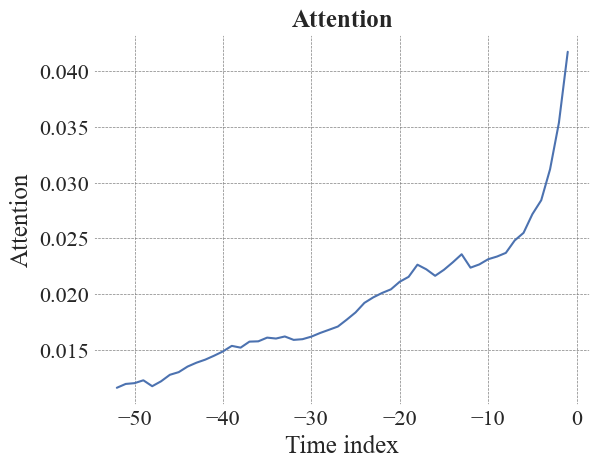

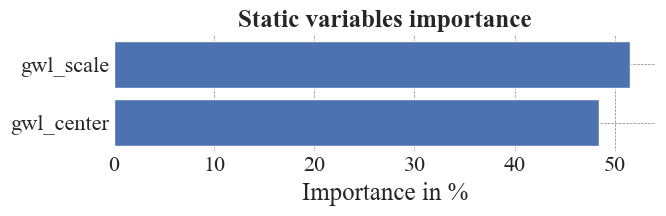

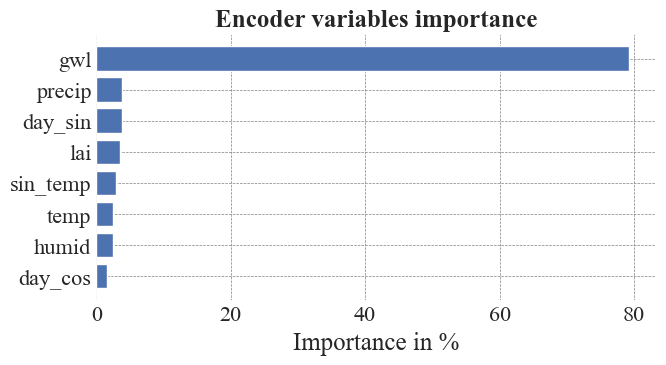

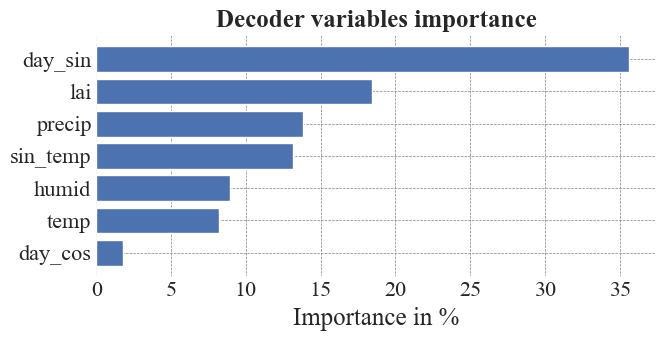

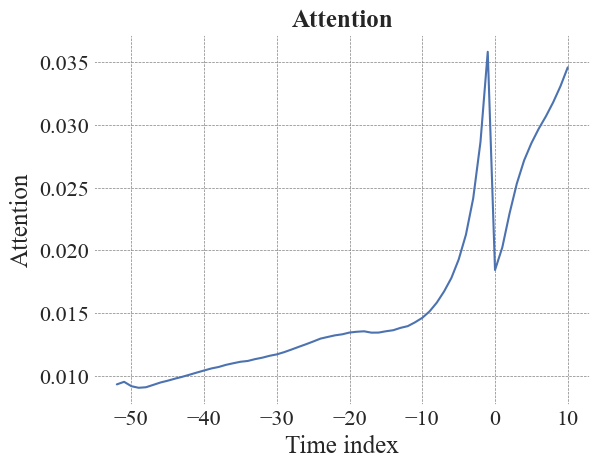

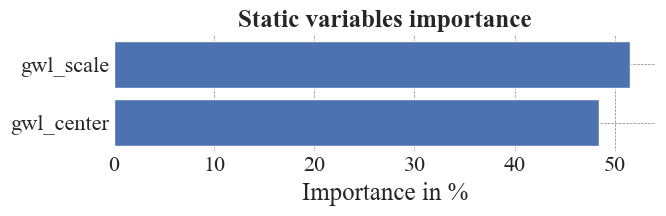

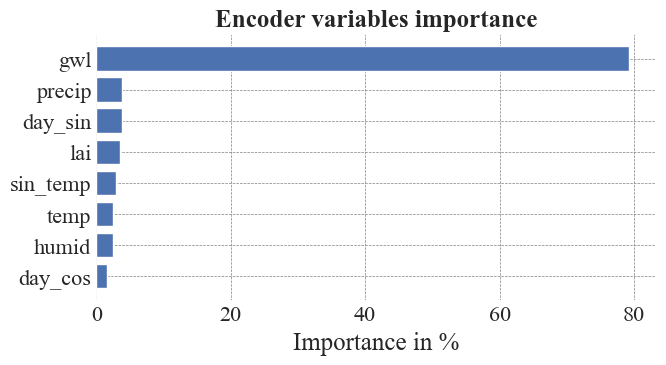

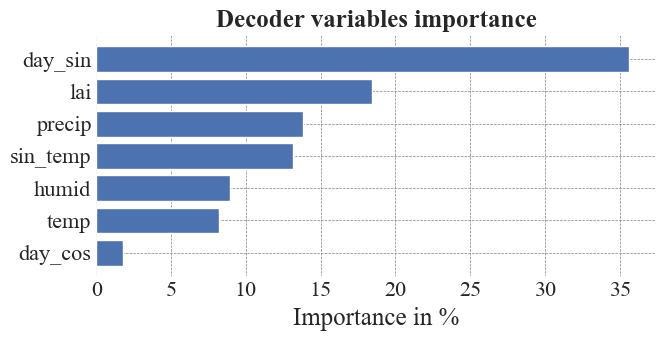

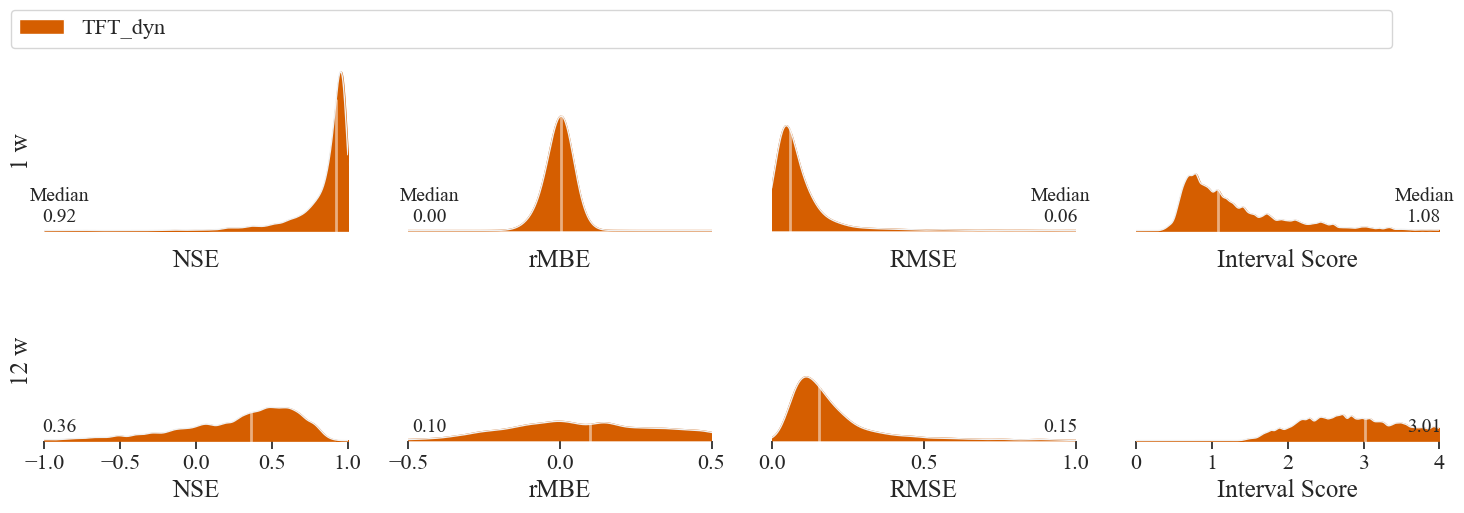

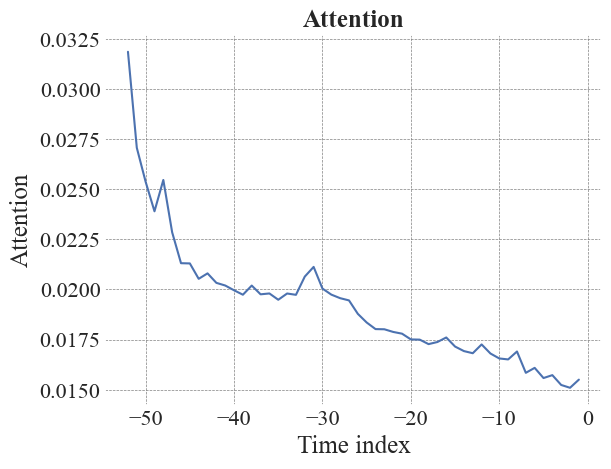

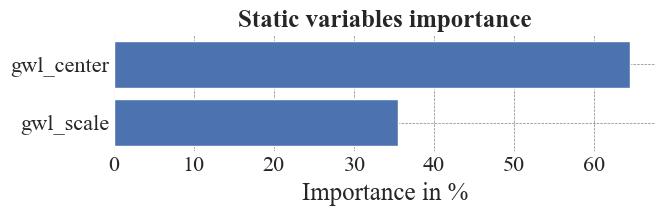

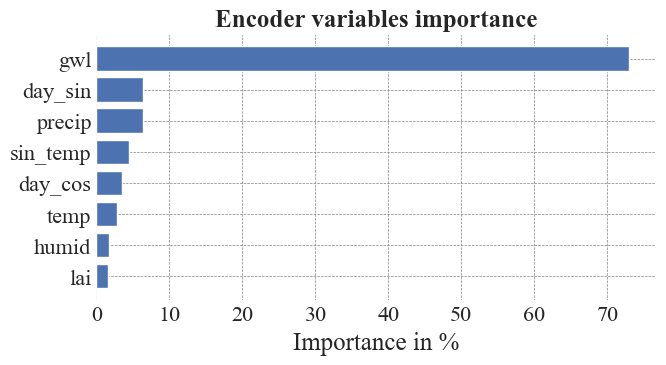

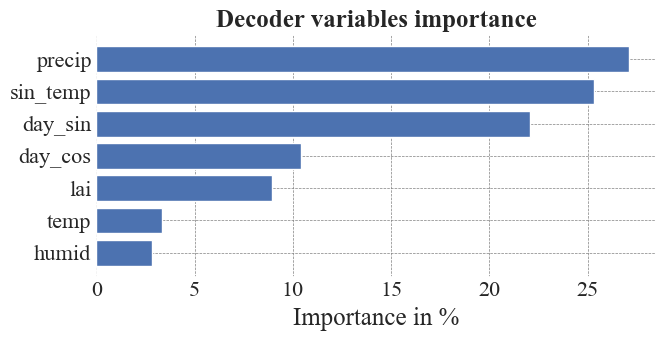

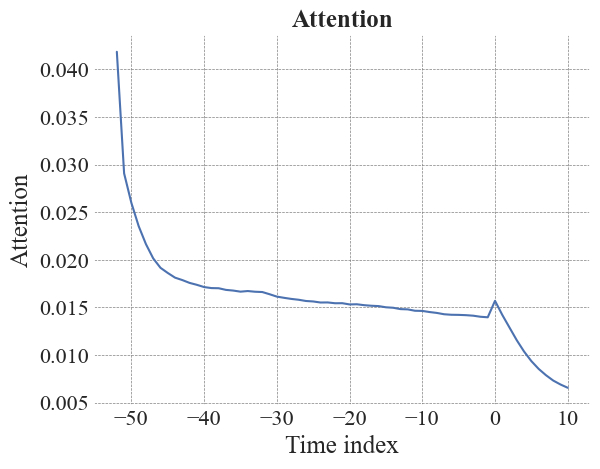

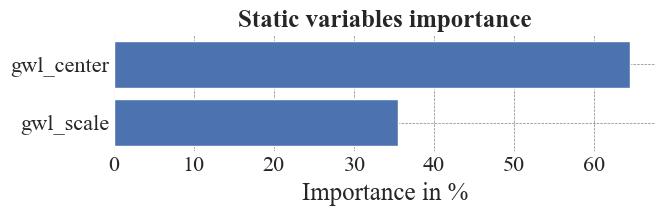

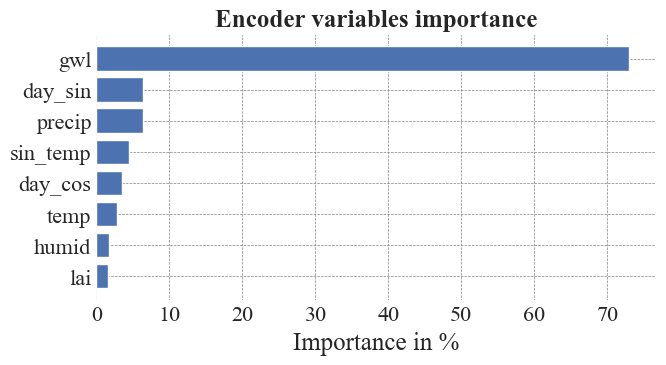

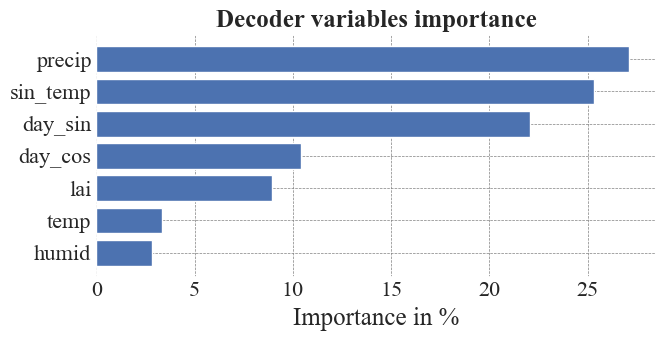

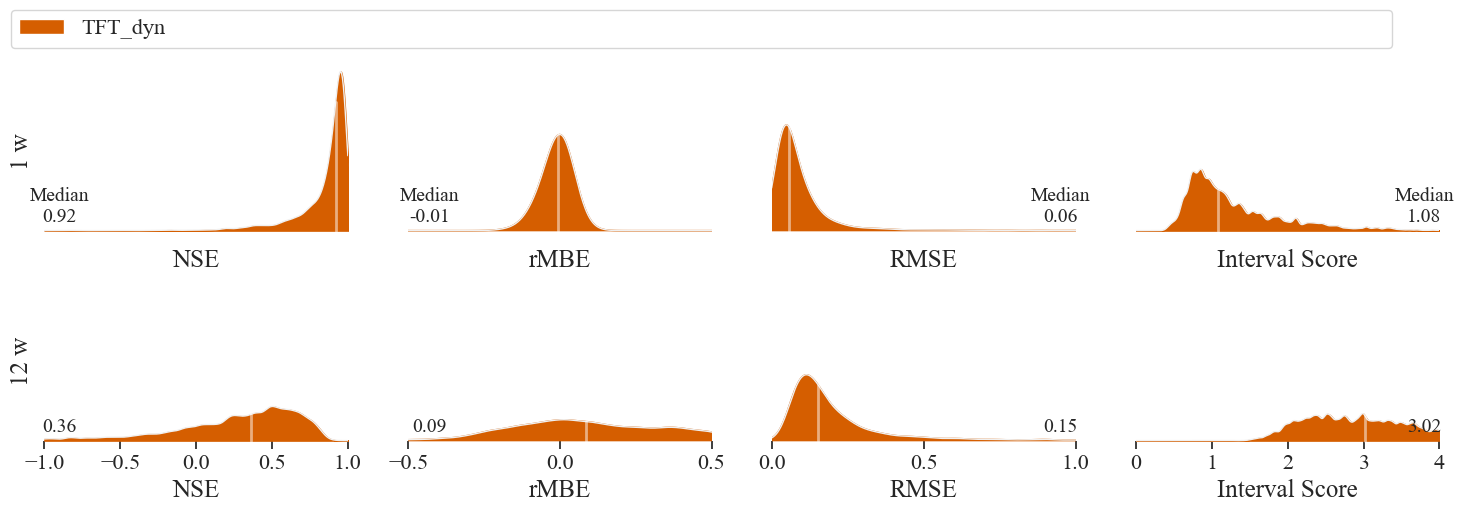

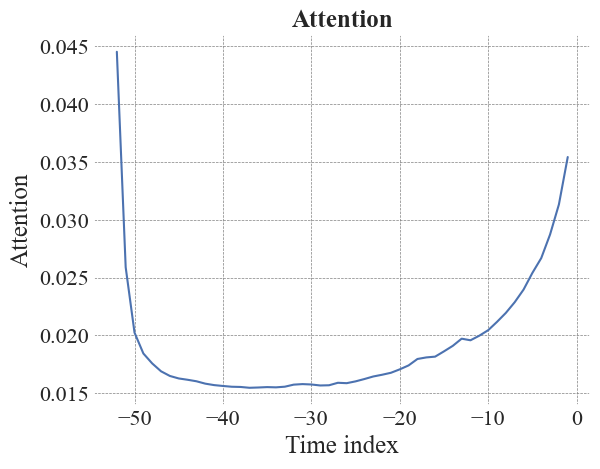

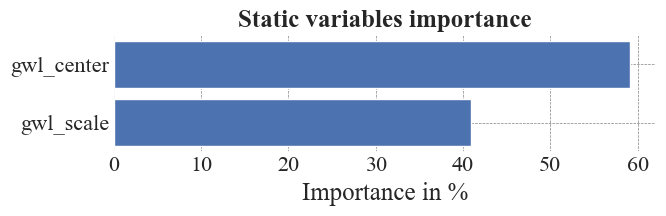

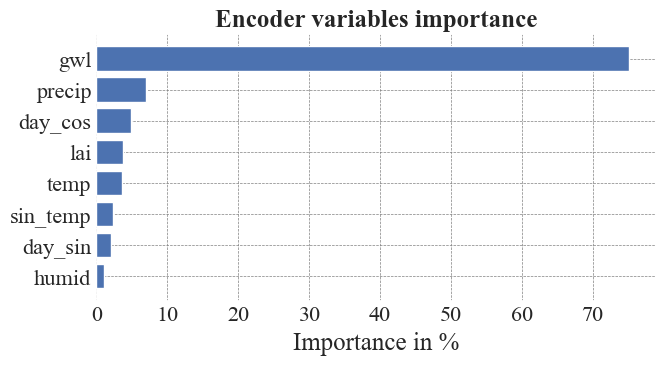

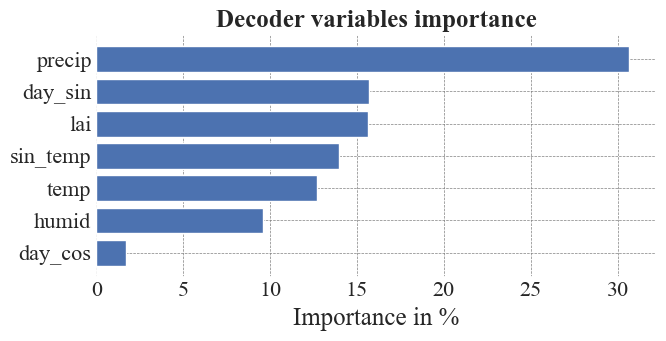

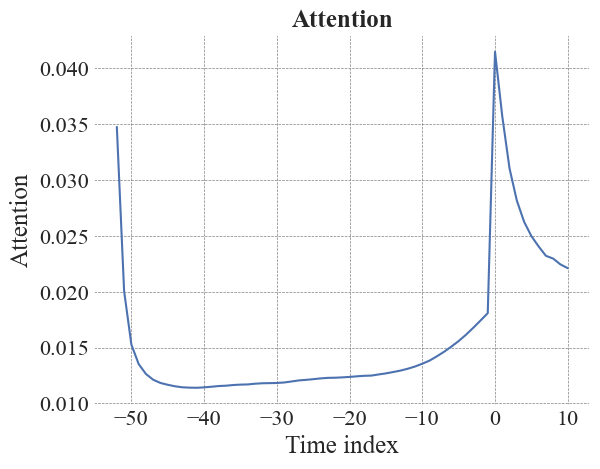

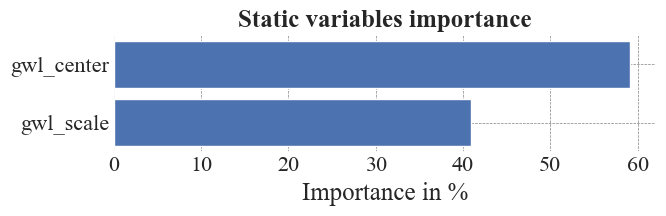

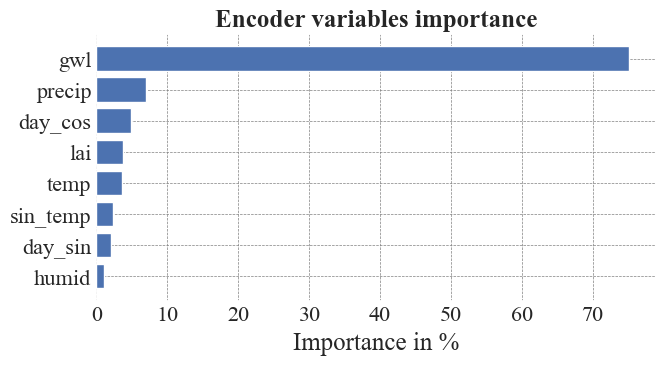

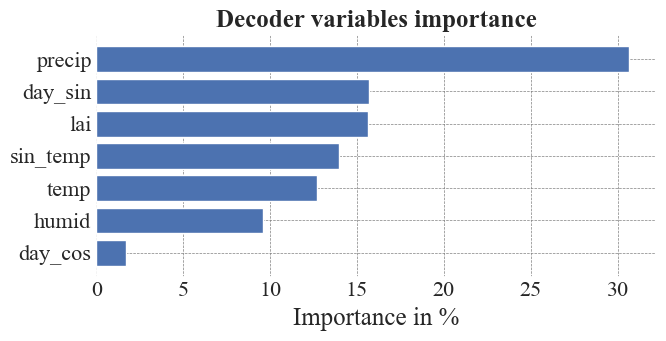

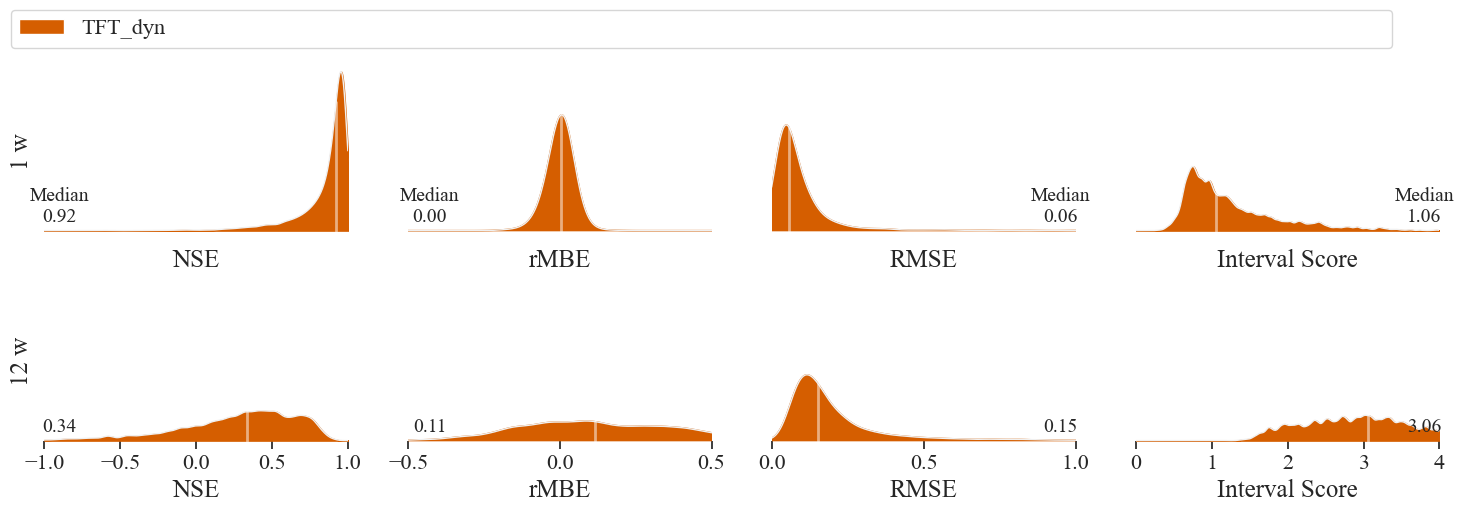

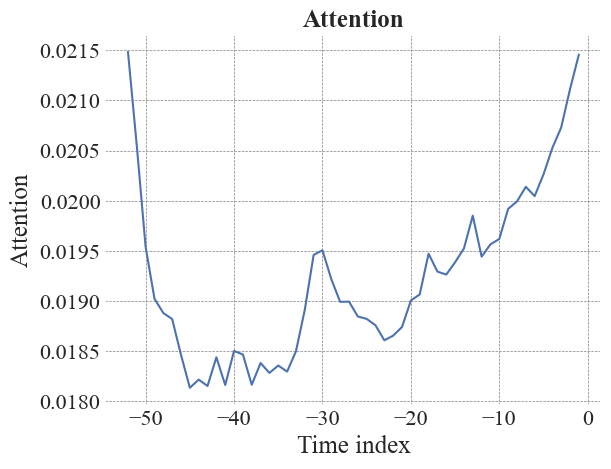

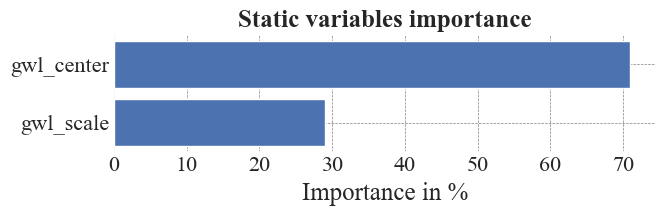

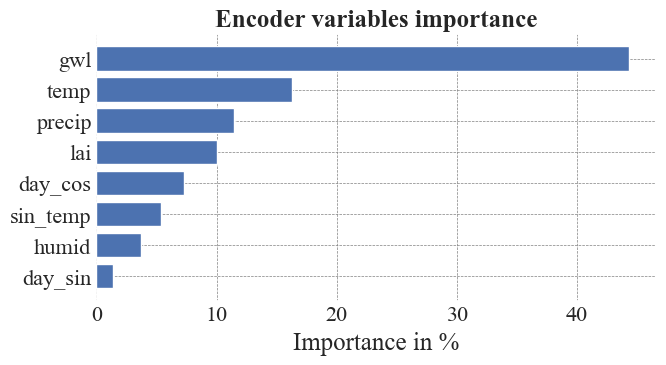

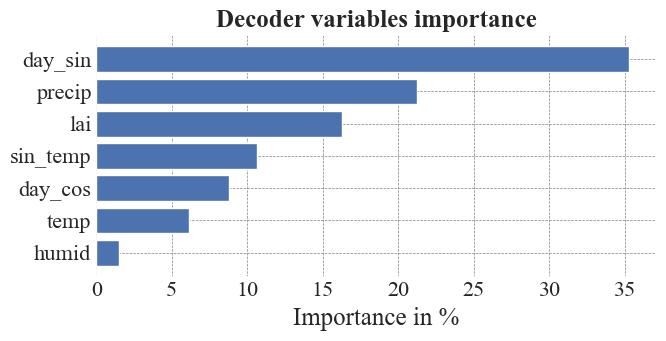

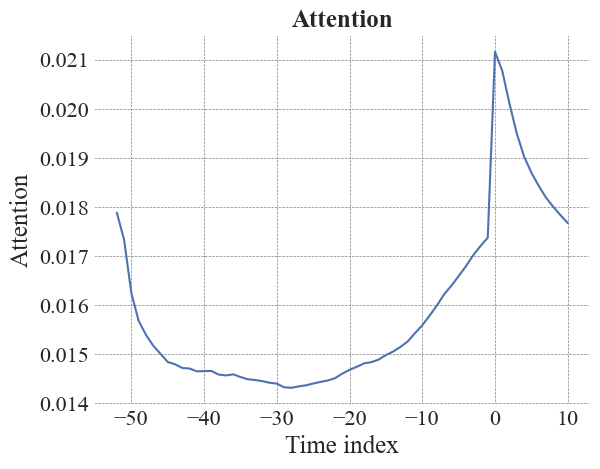

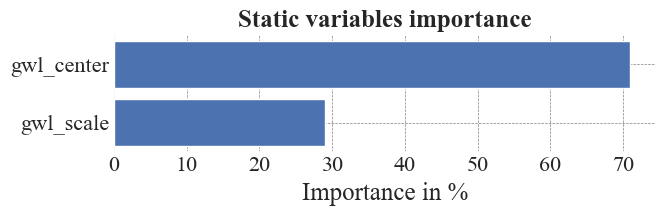

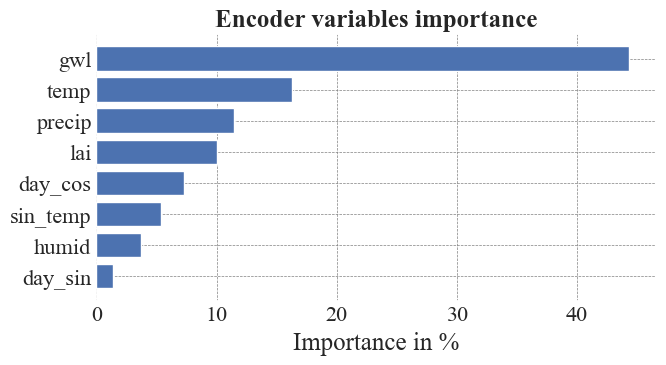

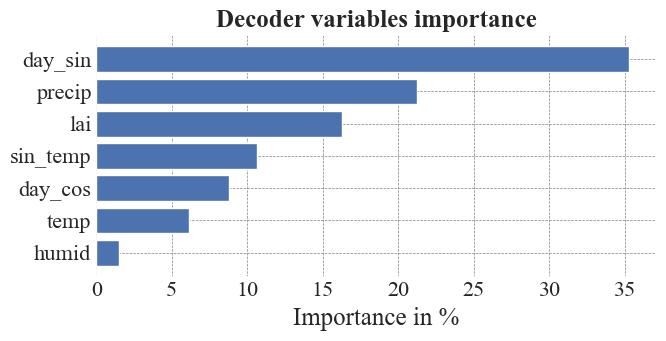

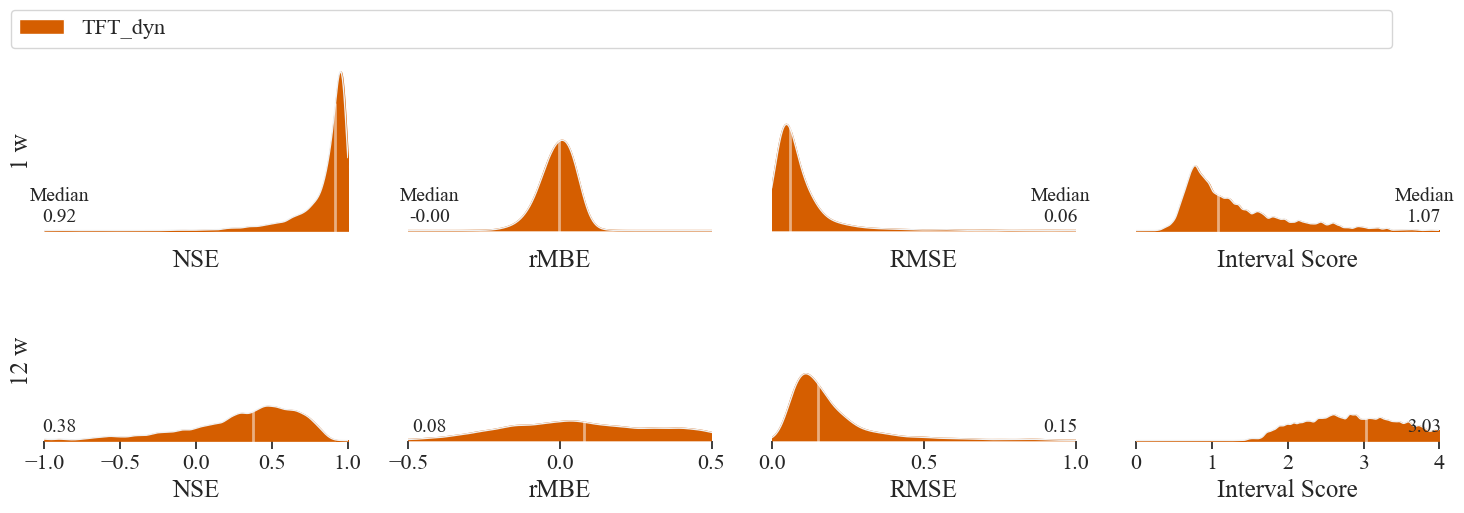

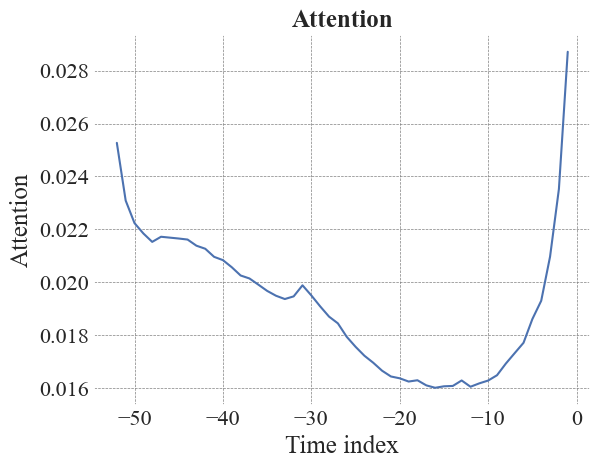

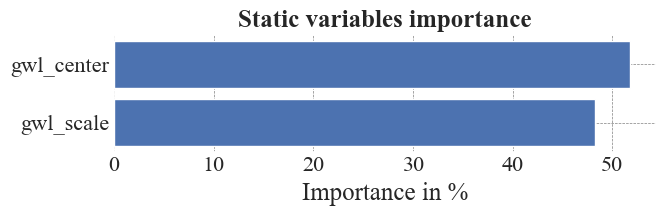

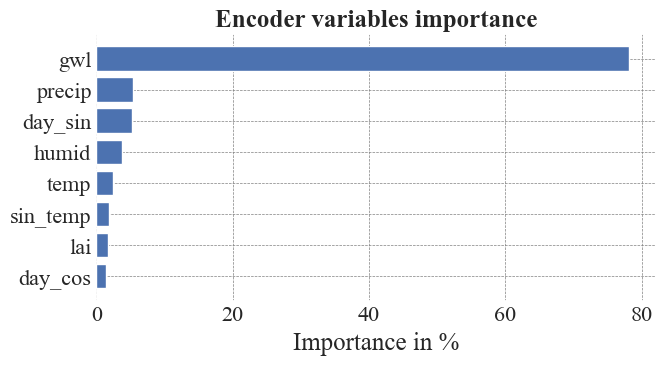

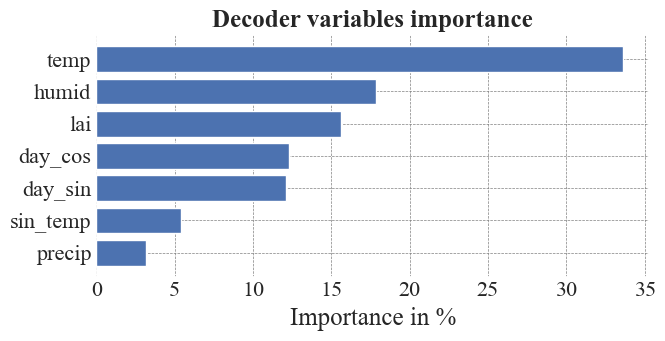

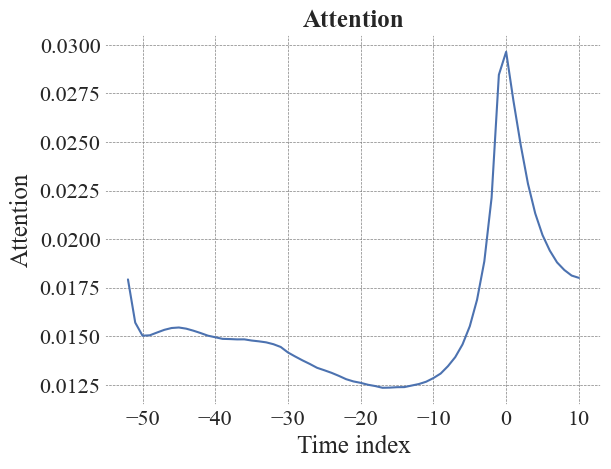

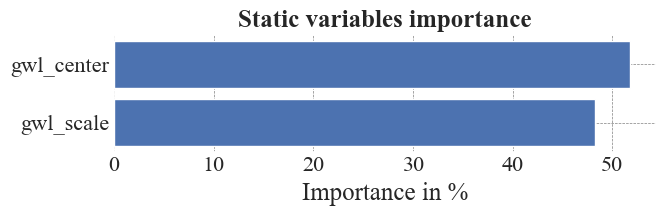

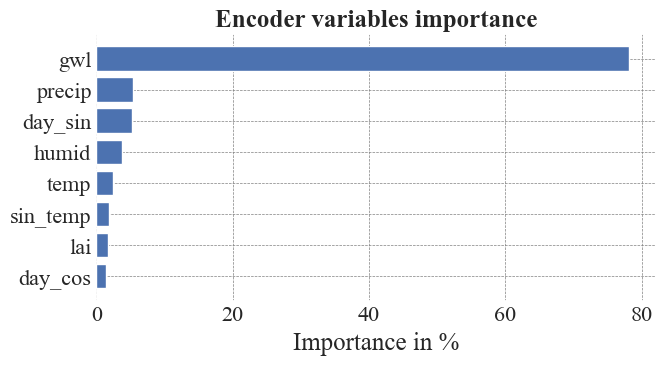

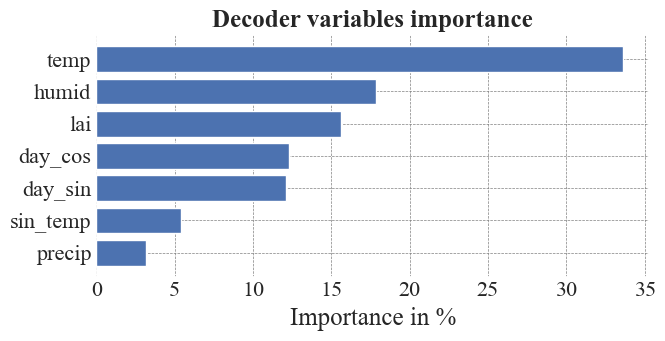

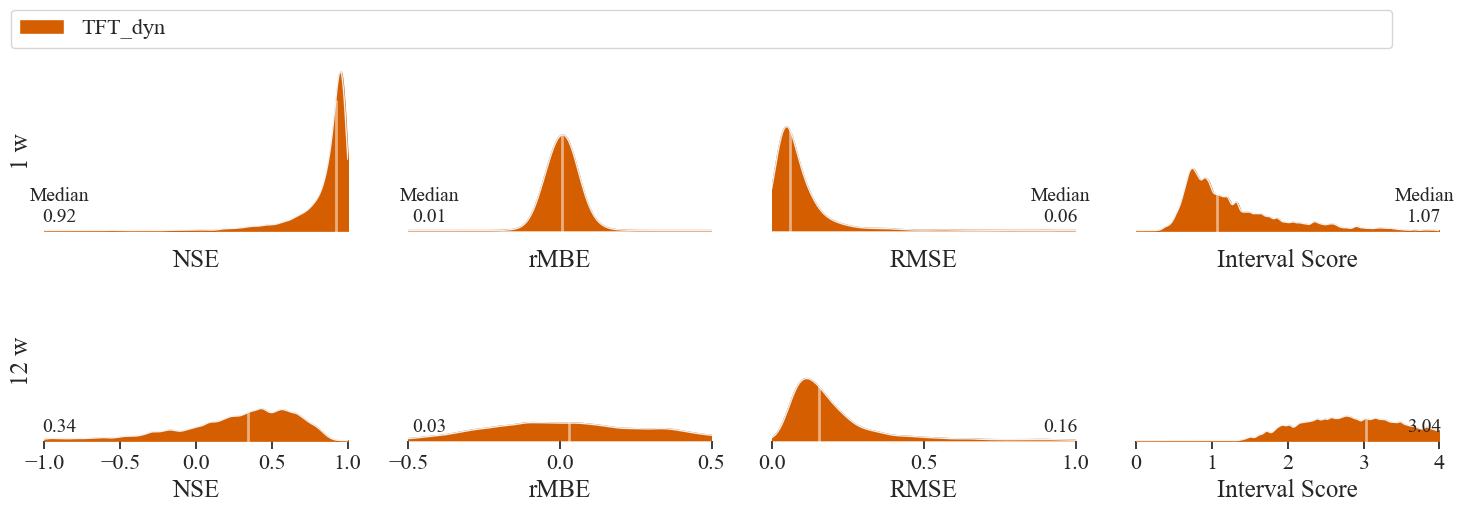

In [12]:
MODEL_TYPE_ls = ['full', 'dyn']

for MODEL_TYPE in MODEL_TYPE_ls: 
    
    # TimeSeriesDataSet for training data
    train_ds = TimeSeriesDataSet.load(os.path.join(SHARE_PATH, 'kimodis_preprocessed', f'train_ds_{MODEL_TYPE}_tft.pt'))
    
    # Create TimeSeries object for testset
    test_ds_in_sample = TimeSeriesDataSet.from_dataset(train_ds, test_df_in_sample) 
    test_dataloader_in_sample = test_ds_in_sample.to_dataloader(train=False, batch_size=1024, num_workers=0)
    
    folder = os.path.join(
        MODEL_PATH, 
       'tft', 
       f'tft_{MODEL_TYPE}',
       f'tft_{MODEL_TYPE}_4096_{VERSION}')

    # list of different versions
    mod_init = [name for name in os.listdir(folder) if re.match('version.*', name)]


    # Loop over the 10 initialisations (versions) and calculate predictions 
    for init in mod_init: 
    
        # Get the different model objects 
        sub_folder = os.path.join(folder, init, 'checkpoints')
        mod_name = [name for name in os.listdir(sub_folder) if re.match('epoch.*', name)]
    
        model = TemporalFusionTransformer.load_from_checkpoint(os.path.join(sub_folder, mod_name[0]))
    
        # Make predictions
        raw_predictions, x, index, y, decoder = model.predict(test_dataloader_in_sample, 
                                                              mode='raw',
                                                              return_index=True, 
                                                              #return_decoder_lengths=True,
                                                              trainer_kwargs=dict(accelerator='cpu', 
                                                                                  devices=1))
    
        ### Feature importance #####################################################################################
        # https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html#pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.interpret_output
        # Use attention_prediction_horizon to get attention curves for different horizons 
        interpretation = model.interpret_output(raw_predictions, 
                                                reduction="sum", 
                                                attention_prediction_horizon=0)
        interpretation_h11 = model.interpret_output(raw_predictions, 
                                                    reduction="sum", 
                                                    attention_prediction_horizon=11)
        tft_interpret_plot = model.plot_interpretation(interpretation)
        tft_interpret_plot_h11 = model.plot_interpretation(interpretation_h11)
    
        for key, fig in tft_interpret_plot.items():
            fig.savefig(os.path.join(BASE_PATH, 
                                     'figures', 
                                     'tft',
                                      f'tft_{MODEL_TYPE}',
                                      f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                      f'tft_{init}_interpret_{key}.png'))
        tft_interpret_plot_h11['attention'].savefig(os.path.join(BASE_PATH, 
                                                                'figures', 
                                                                'tft',
                                                                f'tft_{MODEL_TYPE}',
                                                                f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                                                f'tft_{init}_interpret_attention_h11.png'))
    
        variable_importance = {
            'static_variables': dict(list(zip(model.static_variables, (interpretation['static_variables'].cpu().numpy()/np.sum(interpretation['static_variables'].cpu().numpy())).tolist()))),
            'encoder_variables': dict(list(zip(model.encoder_variables, (interpretation['encoder_variables'].cpu().numpy()/np.sum(interpretation['encoder_variables'].cpu().numpy())).tolist()))),
            'decoder_variables': dict(list(zip(model.decoder_variables, (interpretation['decoder_variables'].cpu().numpy()/np.sum(interpretation['decoder_variables'].cpu().numpy())).tolist())))      
        }
        with open(os.path.join(RESULT_PATH, 
                                'interpretation',
                                'tft',
                                f'tft_{MODEL_TYPE}',
                                f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                f'tft_{init}_variable_importance_{MODEL_TYPE}.json'), 'w') as f:
            json.dump(variable_importance, f)

        # Save to share as well
        with open(os.path.join(SHARE_PATH, 
                               'global_mod_paper',
                               'results',
                               'tft',
                                f'tft_{MODEL_TYPE}',
                                f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                f'tft_{init}_variable_importance_{MODEL_TYPE}.json'), 'w') as f:
            json.dump(variable_importance, f)
    
        # TODO?
        # predictions_vs_actuals = 
        # best_tft.calculate_prediction_actual_by_variable(x, predictions)
        # best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals
        
        ### Assess Predictions #####################################################################################
        from utils import predictions_to_df
    
        predictions = raw_predictions['prediction'].numpy()
    
        tft_pred = predictions_to_df(index, np.transpose(predictions, (2, 1, 0))[3], ['proj_id'], TIME_IDX, LEAD)
        # Extract quantiles
        for q_idx, q_name in [(0, '02'), (1, '10'), (2, '25'), (4, '75'), (5, '90'), (6, '98')]:
            q_df = predictions_to_df(index, np.transpose(predictions, (2, 1, 0))[q_idx], ['proj_id'], TIME_IDX, LEAD)
            tft_pred[f'forecast_q{q_name}'] = q_df['forecast'].values

        # Merge ground truth & save
        tft_pred = tft_pred.reset_index().merge(test_df_in_sample[['proj_id', 'time', 'gwl']], on=['proj_id', 'time'], how='left').set_index(['proj_id', 'time', 'horizon'])
        tft_pred.reset_index().to_feather(os.path.join(RESULT_PATH, 
                                                   'predictions',
                                                   'tft',
                                                    f'tft_{MODEL_TYPE}',
                                                    f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                                    f'in_sample_quantiles_tft_{init}_predictions.feather'))
    
        # Save to share as well
        tft_pred.reset_index().to_feather(os.path.join(SHARE_PATH, 
                                                  'global_mod_paper',
                                                  'results',
                                                  'tft',
                                                   f'tft_{MODEL_TYPE}',
                                                   f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                                   f'in_sample_quantiles_tft_{init}_predictions.feather'))
    
        # NAs are produced in the forecast for horizon 12 
        # tft_pred[tft_pred['forecast'].isnull()]['horizon'].unique()

        # tft_pred[(tft_pred['proj_id']=='TH_5329240536')&(tft_pred['time']=='2013-03-17')]
        # tft_pred.reset_index(inplace=True)
        tft_pred = tft_pred[~tft_pred['forecast'].isnull()]

        # NAs are also present in the gwl variable (ground truth), because TFT predicts until 12 weeks after the 
        # prediction time (hence time is NaT)
        # Can be removed as well
        tft_pred = tft_pred[~tft_pred['gwl'].isnull()]

        # Duplicated values in the forecasts which will be removed for now
        # Original values (predictions, index, x) have the same length
        # len(x['encoder_lengths'].cpu().numpy())
        # len(raw_predictions['prediction'])
        # len(x['decoder_time_idx'])
        tft_pred.reset_index(inplace=True)
        tft_pred = tft_pred[~tft_pred.duplicated(subset=['proj_id', 'time', 'horizon'])]
    
        # TODO out of sample!
        # test_ds_out_sample = TimeSeriesDataSet.from_dataset(train_ds, test_df_out_sample) 
        # test_dataloader_out_sample = test_ds_out_sample.to_dataloader(train=False, batch_size=1024, num_workers=0)
    
        ### Calculate metrics #####################################################################################
    
        from utils import get_metrics

        tft_pred.set_index(['proj_id', 'time', 'horizon'], inplace=True)
        tft_metrics = get_metrics(tft_pred)
        tft_metrics.reset_index(inplace=True)
        tft_metrics.to_feather(os.path.join(RESULT_PATH, 
                                            'metrics',
                                            'tft',
                                            f'tft_{MODEL_TYPE}',
                                            f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                            f'metrics_tft_{init}.feather'))
    
        # Overview table NSE
        nse_table = {f'Median_NSE_TFT_{MODEL_TYPE}': tft_metrics.groupby(['horizon'])['NSE'].median()}
        nse_table = pd.DataFrame(nse_table)
        nse_table.reset_index(inplace=True)
        nse_table.rename(columns={'horizon':'Horizon'}, inplace=True)

        # Save if you wish to
        nse_table.to_csv(os.path.join(RESULT_PATH,
                                      'metrics',
                                      'tft',
                                      f'tft_{MODEL_TYPE}',
                                      f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                      f'median_nse_summary_in_sample_{init}.csv'))

        # Save to share for paper 
        nse_table.to_csv(os.path.join(SHARE_PATH,
                                     'global_mod_paper',
                                     'results',
                                     'tft',
                                      f'tft_{MODEL_TYPE}',
                                      f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                      f'median_nse_summary_in_sample_{init}.csv'))
    
        # Distribution plot error metrics 
        p = palette = sns.color_palette("colorblind")
        colors = [p[3], p[3]] # , p[6], p[3], p[1], p[0], p[2], p[4]

        horizons = [1, 12]

        fig_04, ax = plt.subplots(2, 4, figsize=(18, 5), sharey=True)

        test_position = [-0.9,-0.43,0.95,3.8]
        for j, (metric, _range) in enumerate([('NSE', (-1,1)), ('rMBE', (-0.5, 0.5)), ('RMSE', (0., 1)), ('Interval Score', (0., 4.))]):
            for i, HORIZON in enumerate(horizons):
                x = tft_metrics[(tft_metrics['horizon'] == HORIZON)][metric].replace([np.inf, -np.inf], np.nan).dropna().values
                median = np.median(x)
                x_d = np.linspace(-1,4, 2000)
        
                kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
                kde.fit(x[:, None])
                logprob = kde.score_samples(x_d[:, None])
                y_d = np.exp(logprob)

                if metric == 'NSE':
                    y_d *= 2
                elif metric == 'Interval Score':
                    y_d *= 4
        
                if j == 0:
                    ax[i, j].set_ylabel(f'{HORIZON} w')
            
                # plotting the distribution
                ax[i, j].plot(x_d, y_d, color="#f0f0f0", lw=1)
                ax[i, j].fill_between(x_d, y_d, alpha=1, color=colors[i])
        
                median_index = np.abs(x_d - median).argmin()
                median_y = y_d[median_index]
                ax[i, j].plot((median,median), (0,median_y), color="white", alpha = 0.5, lw=2)   
                if i == 0:
                    ax[i, j].text(test_position[j], 0.4, 'Median\n{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE-4)
                else:
                    ax[i, j].text(test_position[j], 0.4, '{:.2f}'.format(median), va='bottom', ha='center', fontsize = FONT_SIZE-4)
      
                # setting uniform x and y lims
                ax[i, j].set_xlim(_range)
                # ax[i, j].set_ylim(0, 8)

                # make background transparent
                rect = ax[i, j].patch
                rect.set_alpha(0)

                # remove borders, axis ticks, and y labels, set x labels
                ax[i, j].set_yticklabels([])
                ax[i, j].grid(False)
                ax[i, j].set_xlabel(metric)
        
                if i == 1:
                    ax[i, j].xaxis.set_ticks_position('bottom')
                    if j == 1:
                        ax[i, j].set_xticks((-0.5,0,0.5))                
                    elif j==2:
                        ax[i, j].set_xticks((0,0.5,1))
                else:
                    ax[i, j].set_xticklabels([])

                spines = ["top","right","left","bottom"]
                for s in spines:
                    ax[i, j].spines[s].set_visible(False)

        # plt.subplots_adjust(hspace=-.75)
        ylim = ax[0,0].get_ylim()
        legend_elements = [Patch(facecolor=p[3], edgecolor=None, label=f'TFT_{MODEL_TYPE}')]
        fig_04.legend(handles=legend_elements,mode = "expand", bbox_to_anchor=(0.1, 1, 0.78, 0.01))
        fig_04.savefig(os.path.join(FIGURES_PATH, 
                                    'tft',
                                    f'tft_{MODEL_TYPE}',
                                    f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                    f'tft_{init}_metrics.png'), format='png', dpi=300.0)
        fig_04.savefig(os.path.join(SHARE_PATH, 
                                    'global_mod_paper',
                                    'results',
                                    'tft',
                                    f'tft_{MODEL_TYPE}',
                                    f'tft_{MODEL_TYPE}_4096_{VERSION}',
                                    f'tft_{init}_metrics.png'), format='png', dpi=300.0)
#    plt.show()

In [ ]:
# Check performance of tft_interpol for the selected sites of Wunsch et al. (2022)
# sites_wunsch_etal = pd.read_table(os.path.join(SHARE_PATH, 
#                          'global_mod_paper', 
#                          'data',
#                          'sites_wunsch_et_al.csv'))
# sites_wunsch_etal = sites_wunsch_etal['x']
# tft_metrics_wunsch = tft_metrics[tft_metrics['proj_id'].isin(sites_wunsch_etal)]

In [ ]:
# Median NSE for the selected sites of Wunsch et al.
# nse_table_wunsch = {f'Median_NSE_TFT_{MODEL_TYPE}': tft_metrics_wunsch.groupby(['horizon'])['NSE'].median()}
# nse_table_wunsch = pd.DataFrame(nse_table)
# nse_table_wunsch.reset_index(inplace=True)
# nse_table_wunsch.rename(columns={'horizon':'Horizon'}, inplace=True)
# nse_table_wunsch

# Save if you wish to
# nse_table_wunsch.to_csv(os.path.join(RESULT_PATH,
#                              'metrics',
#                             'tft',
#                              f'tft_{MODEL_TYPE}',
#                              f'tft_{MODEL_TYPE}_4096_{VERSION}',
#                              'median_nse_summary_in_sample_wunsch_etal.csv'))

# Save to share for paper 
#nse_table_wunsch.to_csv(os.path.join(SHARE_PATH,
#                             'global_mod_paper',
#                             'results',
#                             'tft',
#                             f'tft_{MODEL_TYPE}',
#                             f'tft_{MODEL_TYPE}_4096_{VERSION}',
#                             'median_nse_summary_in_sample_wunsch_etal.csv'))